In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from itertools import combinations

import sklearn
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as xgb

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\preliminary_models'

### Binning profile data and merging to satellite data

In [3]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

# cut out outlying depth values
profile_df = profile_df[profile_df.PRES < 1001]
# bin the data using 100 bins and group it
out = pd.cut(profile_df.PRES, bins=100, labels=[i for i in range(100)])
profile_df['depth_bin'] = out

depth_profiles = profile_df[['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()
df_depth['date'] = pd.to_datetime(df_depth.date, format='%Y-%m-%d %H:%M:%S')

In [4]:
df_depth

,float,cycleNumber,depth_bin,CHLA,BBP700,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,0,0.704058,0.001789,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,1,1,0.702668,0.001817,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
2,1902303,1,2,0.678800,0.001805,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
3,1902303,1,3,0.668311,0.001771,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
4,1902303,1,4,0.734552,0.001698,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
...,...,...,...,...,...,...,...,...,...,...,...,...
6325631,7901001,15,94,-0.000011,0.000285,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
6325632,7901001,15,95,-0.000246,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
6325633,7901001,15,96,-0.001057,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
6325634,7901001,15,97,-0.002172,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973


### Preprocessing

In [6]:
bins_to_use = [i for i in range(100)]
df = df_depth[df_depth.depth_bin.isin(bins_to_use)]
df["depth_bin"] = df.loc[:, 'depth_bin'].astype("int64").astype("category")
# turn date into radians
df['date_doy'] = df.loc[:, 'date'].apply(lambda x: x.day_of_year)
df['date_doy_rad'] = df.loc[:, 'date_doy'] * (np.pi /182.625)
df

,float,cycleNumber,depth_bin,CHLA,BBP700,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,date_doy,date_doy_rad
0,1902303,1,0,0.704058,0.001789,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,126,2.167505
1,1902303,1,1,0.702668,0.001817,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,126,2.167505
2,1902303,1,2,0.678800,0.001805,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,126,2.167505
3,1902303,1,3,0.668311,0.001771,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,126,2.167505
4,1902303,1,4,0.734552,0.001698,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340,126,2.167505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6325631,7901001,15,94,-0.000011,0.000285,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973,90,1.548218
6325632,7901001,15,95,-0.000246,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973,90,1.548218
6325633,7901001,15,96,-0.001057,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973,90,1.548218
6325634,7901001,15,97,-0.002172,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973,90,1.548218


### Feature merging for selection

In [6]:
df_pic = pd.read_csv('../data/sat_pic_full_final.csv').drop(['sat_pic_day', 'sat_pic_8d', 'short_date'], axis=1)
df_par = pd.read_csv('../data/par_full_final.csv').drop(['par_day', 'par_8d', 'short_date'], axis=1)
df_aph = pd.read_csv('../data/aph_443_full_final.csv').drop(['aph_443_day', 'aph_443_8d', 'short_date'], axis=1)

new_features_df = df_pic.merge(df_par, on=['latitude', 'longitude'])
new_features_df = new_features_df.merge(df_aph, on=['latitude', 'longitude'])

In [7]:
df_round_coords = df.copy()
# round lat and lon to match new data
df_round_coords['latitude'] = df_round_coords.latitude.apply(lambda x: np.around(x, 3))
df_round_coords['longitude'] = df_round_coords.longitude.apply(lambda x: np.around(x, 3))

# merge the new features
model_df = df_round_coords[df_round_coords.depth_bin.isin([0, 3, 6, 9, 12, 15])].merge(new_features_df, on=['latitude', 'longitude']).dropna().drop_duplicates()

### Model Testing

In [8]:
def get_combinations(ls):
    combos = []
    for i in range(len(ls) + 1):
        combos += list(combinations(ls, i))
    return [list(x) for x in combos]

def model_scoring(model, X, y, argument_dict=None, cv=5):
    # for sklearn API compatible gradient boosting models
    
    if not argument_dict:
        # train vanilla model
        cv_results = cross_validate(model, X, y, cv=cv,
                                    scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                    return_estimator=False,
                                    return_train_score=True)
        return cv_results
    else:
        # do a grid search
        gs_results = GridSearchCV(model,
                                  param_grid = [argument_dict], cv=cv,
                                  scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                  refit='neg_root_mean_squared_error',
                                  return_train_score=True)
        gs_results.fit(X, y)
        return gs_results

### Train models using all combinations of feature possibilities

In [9]:
vital_feats = ["latitude", "longitude", "date_doy_rad", "depth_bin"]
added_feats = ["MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST", "sat_pic_month", "par_month", "aph_443_month"]
added_feat_combos = get_combinations(added_feats)
combo_scores = dict()

for c in added_feat_combos:
    Xc_boost = model_df[vital_feats + c]
    yc_boost = model_df["CHLA"]
    X_tr, X_te, y_tr, y_te = train_test_split(Xc_boost, yc_boost, test_size=0.05, random_state=23)

    xgbr = xgb.XGBRegressor(tree_method='gpu_hist')
    xgbr_scoring = model_scoring(xgbr, X_tr.to_numpy(), y_tr.to_numpy(), cv=5)
    combo_scores['__'.join(c)] = xgbr_scoring

### Model performance visualization

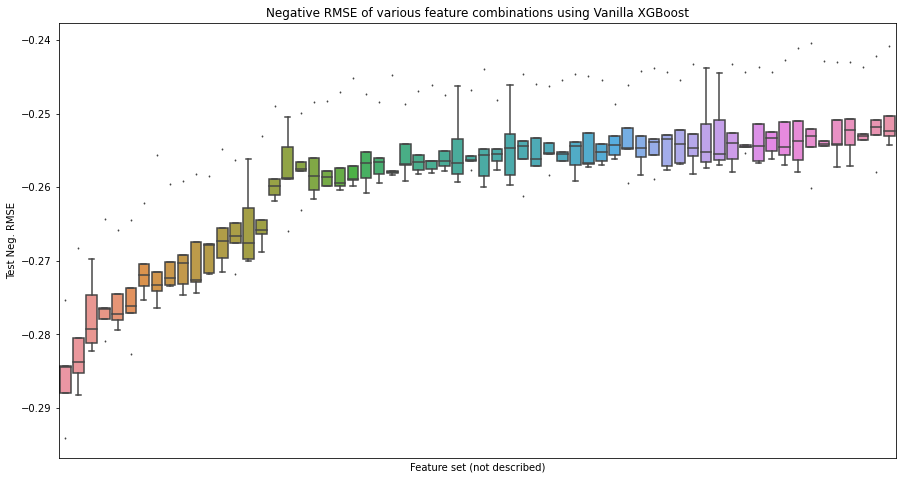

In [10]:
td = {k:v for (k, v) in zip(combo_scores.keys(), [combo_scores[x]['test_neg_root_mean_squared_error'] for x in combo_scores.keys()])}
td_df = pd.DataFrame(td)
mean_td = td_df.reindex(td_df.mean().sort_values().index, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.boxplot(data=mean_td, ax=ax, fliersize=1)
ax.set_ylabel('Test Neg. RMSE')
ax.set_xlabel('Feature set (not described)')
ax.set_title('Negative RMSE of various feature combinations using Vanilla XGBoost')
ax.tick_params(bottom=False, labelbottom=False)
plt.savefig('../visualizations/feature_set_nrmse_w_sat_chla.png')

In [11]:
mean_td.columns[-5:]

Index(['MO_SAT_CHL__MO_SAT_SST__sat_pic_month__aph_443_month',
       'MO_SAT_CHL__MO_SAT_SST__par_month',
       'MO_SAT_CHL__MO_SAT_BBP__MO_SAT_SST__par_month__aph_443_month',
       'MO_SAT_CHL__MO_SAT_SST__sat_pic_month',
       'MO_SAT_CHL__MO_SAT_BBP__MO_SAT_SST__par_month'],
      dtype='object')

### Create pivoted dataframe

In [30]:
piv_df = df_round_coords.merge(new_features_df, on=['latitude', 'longitude']).dropna().drop_duplicates()
pivoted_ls = list()
curr_float, curr_cycle = -1, -1
pivot_row = ''
for i, r in piv_df.iterrows():
    # new cycle
    if (curr_float != r.float) and (curr_cycle != r.cycleNumber):
        pivoted_ls.append(pivot_row)
        curr_float = r.float
        curr_cycle = r.cycleNumber
        pivot_row = {
            'float': curr_float,
            'cycleNumber': curr_cycle,
            'latitude': r.latitude,
            'longitude': r.longitude,
            'date_doy_rad': r.date_doy_rad,
            'sat_chl_month': r.MO_SAT_CHL,
            'sat_sst_month': r.MO_SAT_SST,
            'sat_par_month': r.par_month,
            'sat_pic_month': r.sat_pic_month,
            'sat_aph_443_month': r.aph_443_month
        }
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    # continuing from past cycle
    elif curr_cycle != r.cycleNumber:
        pivoted_ls.append(pivot_row)
        curr_cycle = r.cycleNumber
        pivot_row = {
            'float': curr_float,
            'cycleNumber': curr_cycle,
            'latitude': r.latitude,
            'longitude': r.longitude,
            'date_doy_rad': r.date_doy_rad,
            'sat_chl_month': r.MO_SAT_CHL,
            'sat_sst_month': r.MO_SAT_SST,
            'sat_par_month': r.par_month,
            'sat_pic_month': r.sat_pic_month,
            'sat_aph_443_month': r.aph_443_month
        }
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    else:
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    

**Check missing values in new dataframe (in first 60 bins (0-600 ft of depth)) and impute missing values**

In [43]:
cluster_df = pd.DataFrame(pivoted_ls[1:])
cluster_df.iloc[:, 10:]

,depth_bin_0,depth_bin_1,depth_bin_2,depth_bin_3,depth_bin_4,depth_bin_5,depth_bin_6,depth_bin_7,depth_bin_8,depth_bin_9,...,depth_bin_90,depth_bin_91,depth_bin_92,depth_bin_93,depth_bin_94,depth_bin_95,depth_bin_96,depth_bin_97,depth_bin_99,depth_bin_98
0,0.704058,0.702668,0.678800,0.668311,0.734552,0.932129,1.098108,0.814539,0.684214,0.449756,...,0.005181,0.005181,0.005243,0.005618,0.005306,0.005930,0.005431,0.005930,0.006243,NaN
1,0.691814,0.665761,0.750091,0.769773,0.838611,1.308873,1.385440,0.939163,0.647262,0.436683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.063866,1.064480,0.979005,0.942488,0.954018,1.222963,1.086416,0.848111,0.533261,0.302491,...,0.005071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.432731,1.409791,1.424486,1.514563,1.416844,1.371946,0.883025,0.370423,0.146220,0.090078,...,0.004743,0.005556,0.005743,0.005618,0.006055,0.005993,0.005993,0.004868,0.004681,NaN
4,1.008395,1.038687,1.047004,1.039988,1.044929,1.022055,0.949463,0.244267,0.086929,0.062677,...,0.006305,0.005930,0.006118,0.005618,0.004837,0.004868,0.005431,0.005618,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44707,0.284700,0.284700,0.285048,0.285977,0.239667,0.183173,0.187004,0.164543,0.103475,0.075797,...,0.002083,0.000607,0.000854,0.002476,0.003602,0.003279,0.002099,0.000920,0.000036,0.000036
44708,0.186150,0.186150,0.186150,0.186414,0.179878,0.158747,0.141454,0.098848,0.074134,0.041898,...,-0.000050,-0.000033,-0.000034,-0.000058,-0.000274,-0.001046,-0.001246,-0.001227,-0.000046,-0.000818
44709,0.065700,0.065700,0.067438,0.126242,0.262275,0.232712,0.189794,0.210563,0.087057,0.074056,...,-0.000073,-0.000067,-0.000043,-0.000018,-0.000011,-0.000053,-0.000083,-0.000124,NaN,-0.000135
44710,0.025550,0.026158,0.048106,0.092426,0.140644,0.196006,0.269199,0.184985,0.108543,0.070227,...,0.000054,-0.000022,-0.000956,-0.001261,-0.001543,-0.002013,-0.001258,-0.001257,-0.001257,-0.001257


In [44]:
# if not already saved
'''
cluster_df.iloc[:, 10:] = IterativeImputer().fit_transform(cluster_df.iloc[:, 10:])
cluster_df.to_csv('../data/pivoted_imp_data.csv', index=False)
'''

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Neural Network Architecture Grid Search

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import itertools

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

In [ ]:
# if saved
dists_to_cluster = pd.read_csv('../data/pivoted_imp_data.csv', index_col=False)
# split data
train_dtc, test_dtc = train_test_split(dists_to_cluster, test_size=0.15, random_state=23)
# Cluster the distributions based on FIRST 25 observations (0-260ft)
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(train_dtc.iloc[:, 10:35])
centers = kmeans.cluster_centers_
train_dtc['cluster'] = clusters
dists_to_cluster.shape

In [ ]:
# gather our specific inputs / outputs
X_train_dtc = train_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test_dtc = test_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# outputs: depth_bin_0 (0-10m), depth_bin_3 (30-40m), depth_bin_6 (70-80m), depth_bin_9(90-100m)
label_bins = [0, 3, 6, 9]
Y_train_dtc = train_dtc[['depth_bin_' + str(i) for i in label_bins]]
Y_test_dtc = test_dtc[['depth_bin_' + str(i) for i in label_bins]]

input_dim = X_train_dtc.shape[1]
output_dim = Y_train_dtc.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train_dtc)
X_train_dtc = scaler.transform(X_train_dtc)
X_test_dtc = scaler.transform(X_test_dtc)

In [ ]:
### Do some grid search on neural net
param_dict = {
    'l1': np.linspace(12, 108, 12).astype('int').tolist(),
    'l2': np.linspace(4, 28, 3).astype('int').tolist(),
    'do': [0.2, 0.3, 0.4]
    }
keys, values = zip(*param_dict.items())
perm_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
gs_mses = list()
for d in perm_dicts:
    nn_model = Sequential()

    nn_model.add(Dense(d['l1'], input_dim=input_dim, activation='relu'))
    nn_model.add(Dropout(d['do']))
    nn_model.add(Dense(d['l2'], activation='relu'))
    nn_model.add(Dropout(d['do']))
    nn_model.add(Dense(output_dim))

    nn_model.compile(loss='mse', optimizer='adam')

    nn_model.fit(X_train_dtc, Y_train_dtc, epochs=10, batch_size=32, verbose=0)

    preds = nn_model.predict(X_test_dtc)
    actuals = Y_test_dtc.to_numpy()
    gs_mses.append(mean_squared_error(actuals, preds))

# best params
print(perm_dicts[np.argmin(np.array(gs_mses))])
# best mse
print(min(gs_mses))
# plot sorted mses
plt.plot(sorted(gs_mses))

In [ ]:
import itertools
### Do some grid search on neural net
param_dict = {
    'l1': np.linspace(128, 256, 5).astype('int').tolist(),
    'l2': np.linspace(40, 100, 5).astype('int').tolist(),
    'do': [0.2]
    }
keys, values = zip(*param_dict.items())
perm_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
gs_mses = {
    'test': [],
    'train': []
}
for d in perm_dicts:
    nn_model = Sequential()

    nn_model.add(Dense(d['l1'], input_dim=input_dim, activation='relu'))
    nn_model.add(Dropout(d['do']))
    nn_model.add(Dense(d['l2'], activation='relu'))
    nn_model.add(Dropout(d['do']))
    nn_model.add(Dense(output_dim))

    nn_model.compile(loss='mse', optimizer='adam')

    nn_model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=0)

    te_preds = nn_model.predict(X_test, verbose=0)
    te_actuals = Y_test.to_numpy()

    tr_preds = nn_model.predict(X_train, verbose=0)
    tr_actuals = Y_train.to_numpy()

    gs_mses['test'].append(mean_squared_error(te_actuals, te_preds))
    gs_mses['train'].append(mean_squared_error(tr_actuals, tr_preds))
    print(f'{d} complete')


In [1]:
gs_mses = {'test': [0.10018461712452635, 0.09326656247439909, 0.09271206566873115, 0.0962847898656196, 0.0931598656589224, 0.09481680815079024, 0.09300194745338254, 0.09566548264262154, 0.09432682848913071, 0.09537165017284355, 0.09332457067727461, 0.09318455433223219, 0.09468407101892765, 0.09221052371605745, 0.09246607845534781, 0.09508610365126553, 0.0980028420162195, 0.09221964992020014, 0.09821433361656322, 0.09195745149618531, 0.09592270165918204, 0.09397403407028014, 0.09285429145510712, 0.09360197403715922, 0.09177887620391006], 'train': [0.09855737930841589, 0.09150651230143836, 0.09100961499297781, 0.09224594569658329, 0.09252325224373503, 0.09472895139043146, 0.09094085063884598, 0.09513851502312416, 0.0930414288434843, 0.09364294011457647, 0.09179519703491645, 0.0917020547279552, 0.09286200716646477, 0.09055890722783635, 0.09006789658577209, 0.09432166682377682, 0.09491223652262984, 0.09096090386195199, 0.0943495444473228, 0.09033671001910118, 0.09527063098358736, 0.09205971052037014, 0.09058818179670025, 0.09081419862063762, 0.08909607859325006]}
features_uses = [{'l1': 128, 'l2': 40, 'do': 0.2}, {'l1': 128, 'l2': 55, 'do': 0.2}, {'l1': 128, 'l2': 70, 'do': 0.2}, {'l1': 128, 'l2': 85, 'do': 0.2}, {'l1': 128, 'l2': 100, 'do': 0.2}, {'l1': 160, 'l2': 40, 'do': 0.2}, {'l1': 160, 'l2': 55, 'do': 0.2}, {'l1': 160, 'l2': 70, 'do': 0.2}, {'l1': 160, 'l2': 85, 'do': 0.2}, {'l1': 160, 'l2': 100, 'do': 0.2}, {'l1': 192, 'l2': 40, 'do': 0.2}, {'l1': 192, 'l2': 55, 'do': 0.2}, {'l1': 192, 'l2': 70, 'do': 0.2}, {'l1': 192, 'l2': 85, 'do': 0.2}, {'l1': 192, 'l2': 100, 'do': 0.2}, {'l1': 224, 'l2': 40, 'do': 0.2}, {'l1': 224, 'l2': 55, 'do': 0.2}, {'l1': 224, 'l2': 70, 'do': 0.2}, {'l1': 224, 'l2': 85, 'do': 0.2}, {'l1': 224, 'l2': 100, 'do': 0.2}, {'l1': 256, 'l2': 40, 'do': 0.2}, {'l1': 256, 'l2': 55, 'do': 0.2}, {'l1': 256, 'l2': 70, 'do': 0.2}, {'l1': 256, 'l2': 85, 'do': 0.2}, {'l1': 256, 'l2': 100, 'do': 0.2}]